In [1]:
!pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.6/23.6 MB 108.8 MB/s eta 0:00:00


In [10]:
# DPR with ICT-P (paper-style)
# - Bi-encoder (mBERT) query+passage encoders
# - Pre-finetune on MS MARCO, then fine-tune on Mr.TyDi (or your combined set)
# - ICT-P: cluster passage representations before each epoch and build batches from clusters
# - In-batch contrastive (DPR negative log-likelihood) loss using dot product similarity
#
# NOTE: Paper defaults: pre_epochs=40, ft_epochs=40, batch_size=16, lr=1e-5
# Those settings require substantial GPU (>=32GB). For Kaggle/Colab use smaller values below.

import os, math, random, time, json
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["WANDB_DISABLED"] = "true"
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:128"  # optional to reduce fragmentation

import numpy as np
import pandas as pd
from sklearn.cluster import MiniBatchKMeans
from tqdm.auto import tqdm
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from transformers import AutoModel, AutoTokenizer, get_linear_schedule_with_warmup
from torch.optim import AdamW
import faiss
import gc

# -------------------------
# Config (edit to your env)
# -------------------------
MSMARCO_CSV = "/content/msmarco_triples.csv"   # must have columns: query, positive, (optional negative)
TYDI_DIR    = "/content"                       # contains mrtydi_<lang>.json/.jsonl (optional)
OUTPUT_DIR  = "/content/ict_p"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Paper settings (defaults in paper)
PAPER_PRE_EPOCHS = 40
PAPER_FT_EPOCHS  = 40
PAPER_BATCH_SIZE = 16
PAPER_LR = 1e-5

# Safe defaults (for local/Kaggle): you can increase if you have larger GPU
PRE_EPOCHS = 5      # set to PAPER_PRE_EPOCHS for full reproductions
FT_EPOCHS  = 5        # set to PAPER_FT_EPOCHS for full reproductions
BATCH_SIZE = 4          # paper used 16; reduce if OOM
LR         = 1e-5
ACCUM_STEPS = 1         # gradient accumulation (increase if you need effective larger batch)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_NAME = "bert-base-multilingual-cased"  # paper uses mBERT (bert-base-multilingual-cased)
MAX_LEN = 64           # token length for queries/passages (increase if passages are longer)
POOLING = "mean"       # pooling strategy for sentence embedding
CLUSTERING_K_FACTOR = 1.0  # k = ceil(num_passages / (BATCH_SIZE*CLUSTERING_K_FACTOR)) adjust for cluster size
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if DEVICE.startswith("cuda"):
    torch.cuda.manual_seed_all(SEED)

# -------------------------
# Helpers: dataset & tokenize
# -------------------------
class QPDataset(Dataset):
    def __init__(self, rows):
        # rows is a list of dicts: {"q":..., "pos":...}
        self.rows = rows
    def __len__(self):
        return len(self.rows)
    def __getitem__(self, idx):
        r = self.rows[idx]
        return r["q"], r["pos"], idx

def collate_texts_texts(batch, tokenizer, max_len=MAX_LEN):
    # batch: list of (q, pos, idx)
    queries = [b[0] for b in batch]
    passages = [b[1] for b in batch]
    q_tokens = tokenizer(queries, padding=True, truncation=True, max_length=max_len, return_tensors="pt")
    p_tokens = tokenizer(passages, padding=True, truncation=True, max_length=max_len, return_tensors="pt")
    return q_tokens, p_tokens

def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0]   # (batch, seq_len, dim)
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask

# -------------------------
# DPR model wrapper
# -------------------------
class DPR_BiEncoder(nn.Module):
    def __init__(self, model_name):
        super().__init__()
        # Two independent mBERT models (query and passage encoders)
        self.q_encoder = AutoModel.from_pretrained(model_name)
        self.p_encoder = AutoModel.from_pretrained(model_name)
        # optional projection (paper uses raw BERT outputs -> dot product)
        # you may add a projection to reduce dim if wanted
        # self.proj = nn.Linear(self.q_encoder.config.hidden_size, 768)
    def forward_query(self, input_ids, attention_mask):
        out = self.q_encoder(input_ids=input_ids, attention_mask=attention_mask, return_dict=False)
        emb = mean_pooling(out, attention_mask)
        return emb
    def forward_passage(self, input_ids, attention_mask):
        out = self.p_encoder(input_ids=input_ids, attention_mask=attention_mask, return_dict=False)
        emb = mean_pooling(out, attention_mask)
        return emb
    def to_device(self, device):
        self.to(device)

# -------------------------
# Utility: encode texts in batches (CPU/GPU safe)
# -------------------------
def encode_texts_encoder(encoder_model, tokenizer, texts, device, batch_size=64, max_len=MAX_LEN, is_query=False):
    encoder_model.eval()
    all_embs = []
    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i+batch_size]
            toks = tokenizer(batch_texts, padding=True, truncation=True, max_length=max_len, return_tensors="pt")
            input_ids = toks["input_ids"].to(device)
            attn = toks["attention_mask"].to(device)
            if is_query:
                out = encoder_model.forward_query(input_ids, attn)
            else:
                out = encoder_model.forward_passage(input_ids, attn)
            all_embs.append(out.cpu().numpy())
    return np.vstack(all_embs)

# -------------------------
# Loss: in-batch DPR NLL
# -------------------------
def inbatch_dpr_loss(q_emb, p_emb, temperature=1.0):
    # q_emb: (B, D) ; p_emb: (B, D)
    # compute similarity matrix
    logits = torch.matmul(q_emb, p_emb.t()) / temperature
    labels = torch.arange(q_emb.size(0), device=q_emb.device)
    loss_fn = nn.CrossEntropyLoss()
    loss = loss_fn(logits, labels)
    # compute simple metrics (recall@1)
    with torch.no_grad():
        preds = logits.argmax(dim=1)
        r1 = (preds == labels).float().mean().item()
    return loss, r1

# -------------------------
# ICT-P training epoch (cluster passages, build batches)
# -------------------------
def build_ictp_batches(passage_embeddings, batch_size, k_factor=CLUSTERING_K_FACTOR, seed=SEED):
    # passage_embeddings: numpy (N, D)
    N = passage_embeddings.shape[0]
    # number of clusters
    # Paper: cluster into k clusters -> then sub-split into batches of size b
    # simple heuristic: k = ceil(N / (b * k_factor))
    k = max(1, int(math.ceil(N / (batch_size * k_factor))))
    # MiniBatchKMeans for speed
    mbk = MiniBatchKMeans(n_clusters=k, random_state=seed, batch_size=1024)
    mbk.fit(passage_embeddings)
    labels = mbk.labels_
    # group indices by cluster
    clusters = {}
    for idx, c in enumerate(labels):
        clusters.setdefault(c, []).append(idx)
    # for each cluster, split into chunks of size batch_size
    batches = []
    for c_idx, idxs in clusters.items():
        # shuffle indices within cluster to add randomness
        random.shuffle(idxs)
        for i in range(0, len(idxs), batch_size):
            chunk = idxs[i:i+batch_size]
            if len(chunk) < batch_size:
                # we can either drop small tail or pad by sampling random others from same cluster
                # Paper combined small sub-clusters until size b (they combine small subclusters). We approximate:
                # Skip tiny tails to keep balanced batches (or pad by random choices to full size)
                # Here we will skip tails smaller than batch_size // 2 to avoid tiny batches
                if len(chunk) < max(1, batch_size//2):
                    continue
                # else include the smaller tail as a batch
            batches.append(chunk)
    # shuffle batches globally
    random.shuffle(batches)
    return batches

# -------------------------
# Training loops
# -------------------------
def train_stage(model, tokenizer, train_rows, epochs, batch_size, lr, device, stage_name="FT", clustering=True, update_every_epoch=True, save_prefix="model_stage"):
    """
    train_rows: list of {"q":..., "pos":...}
    """
    model.to(device)
    optimizer = AdamW(list(model.q_encoder.parameters()) + list(model.p_encoder.parameters()), lr=lr)
    total_steps = max(1, (len(train_rows) // batch_size) * epochs)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps= max(1, int(0.01*total_steps)), num_training_steps=total_steps)
    # For gradient accumulation
    scaler = torch.cuda.amp.GradScaler(enabled=(device.startswith("cuda")))
    global_step = 0

    # Prepare tokenizer shortcuts
    def tokenize_qs(texts):
        return tokenizer(texts, padding=True, truncation=True, max_length=MAX_LEN, return_tensors="pt")
    def tokenize_ps(texts):
        return tokenizer(texts, padding=True, truncation=True, max_length=MAX_LEN, return_tensors="pt")

    for epoch in range(1, epochs+1):
        print(f"\n=== {stage_name} epoch {epoch}/{epochs} ===")
        model.train()

        # ICT-P clustering: compute passage embeddings and cluster
        if clustering:
            print("Encoding all passages for clustering (batch)...")
            passages = [r["pos"] for r in train_rows]
            # encode using passage encoder
            p_embs = encode_texts_encoder(model, tokenizer, passages, device, batch_size=128, max_len=MAX_LEN, is_query=False)
            print("Passage embeddings shape:", p_embs.shape)
            # build batches from clusters
            batches = build_ictp_batches(p_embs, batch_size)
            print("Number of batches (clustered):", len(batches))
        else:
            # simple sequential batching
            N = len(train_rows)
            indices = list(range(N))
            random.shuffle(indices)
            batches = [indices[i:i+batch_size] for i in range(0, N, batch_size)]
            print("Number of batches (sequential):", len(batches))

        epoch_loss = 0.0
        epoch_r1 = 0.0
        pbar = tqdm(batches, desc=f"{stage_name}-epoch{epoch}")
        optimizer.zero_grad()
        for step, batch_idxs in enumerate(pbar):
            # build lists of queries & passages from indices
            qs = [train_rows[i]["q"] for i in batch_idxs]
            ps = [train_rows[i]["pos"] for i in batch_idxs]
            # tokenize
            q_toks = tokenizer(qs, padding=True, truncation=True, max_length=MAX_LEN, return_tensors="pt")
            p_toks = tokenizer(ps, padding=True, truncation=True, max_length=MAX_LEN, return_tensors="pt")

            q_input_ids = q_toks["input_ids"].to(device)
            q_attn = q_toks["attention_mask"].to(device)
            p_input_ids = p_toks["input_ids"].to(device)
            p_attn = p_toks["attention_mask"].to(device)

            # forward with mixed-precision if GPU
            with torch.cuda.amp.autocast(enabled=(device.startswith("cuda"))):
                q_emb = model.forward_query(q_input_ids, q_attn)   # (B, D)
                p_emb = model.forward_passage(p_input_ids, p_attn) # (B, D)
                loss, r1 = inbatch_dpr_loss(q_emb, p_emb, temperature=1.0)

            scaler.scale(loss).backward()

            if (step + 1) % ACCUM_STEPS == 0:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(list(model.parameters()), max_norm=1.0)  # optional
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
                scheduler.step()
                global_step += 1

            epoch_loss += loss.item()
            epoch_r1 += r1
            pbar.set_postfix(loss=epoch_loss/(step+1), r1=epoch_r1/(step+1))

            # free mem each step
            del q_input_ids, q_attn, p_input_ids, p_attn, q_emb, p_emb, loss
            torch.cuda.empty_cache()

        # epoch summary
        avg_loss = epoch_loss / max(1, len(batches))
        avg_r1 = epoch_r1 / max(1, len(batches))
        print(f"Epoch {epoch} summary - loss: {avg_loss:.4f}  Recall@1 (batch): {avg_r1:.4f}")

        # optionally update representations less frequently (paper updated every 10 epochs for iterative methods)
        # here we recompute passages at every epoch because we cluster every epoch (ICT-P)
        # Save model checkpoint
        ckpt_path = os.path.join(OUTPUT_DIR, f"{save_prefix}_epoch{epoch}.pt")
        torch.save({
            "epoch": epoch,
            "model_state": {"q_encoder": model.q_encoder.state_dict(), "p_encoder": model.p_encoder.state_dict()},
            "optimizer": optimizer.state_dict(),
            "scheduler": scheduler.state_dict()
        }, ckpt_path)
        print("Saved checkpoint:", ckpt_path)

    print("Training stage done.")
    return model

# -------------------------
# Load MS MARCO + MrTyDi (simple robust loaders)
# -------------------------
def load_msm_csv(path, sample_limit=1000, seed=SEED):
    df = pd.read_csv(
        path,
        engine="python",
        on_bad_lines="skip",
        quoting=3
    )
    cols = {c.lower():c for c in df.columns}
    if "query" not in cols or "positive" not in cols:
        raise ValueError("MSMARCO CSV must have columns 'query' and 'positive' (case-insensitive).")
    qcol = cols["query"]; pcol = cols["positive"]; ncol = cols.get("negative", None)
    if sample_limit:
        df = df.sample(sample_limit, random_state=seed).reset_index(drop=True)
    rows = []
    for _, r in df.iterrows():
        rows.append({"q": str(r[qcol]), "pos": str(r[pcol])})
    return rows

def load_mrtydi_from_dir(tydi_dir, per_lang_limit=100):
    # robustly load mrtydi_*.json(.jsonl)
    rows = []
    for fn in sorted(os.listdir(tydi_dir)):
        if fn.lower().startswith("mrtydi_") and (fn.lower().endswith(".json") or fn.lower().endswith(".jsonl")):
            path = os.path.join(tydi_dir, fn)
            try:
                with open(path, "r", encoding="utf8") as f:
                    first = f.read(1)
                    f.seek(0)
                    if first.strip().startswith("["):
                        arr = json.load(f)
                        for ob in arr[:per_lang_limit] if per_lang_limit else arr:
                            q = ob.get("query") or ob.get("question") or ob.get("query_text") or ""
                            p = ob.get("positive_passage") or ob.get("positive") or ob.get("passage") or ob.get("text") or ""
                            if q and p:
                                rows.append({"q": str(q), "pos": str(p)})
                    else:
                        for i,line in enumerate(f):
                            if per_lang_limit and i>=per_lang_limit: break
                            if not line.strip(): continue
                            try:
                                ob = json.loads(line)
                            except:
                                continue
                            q = ob.get("query") or ob.get("question") or ob.get("query_text") or ""
                            p = ob.get("positive_passage") or ob.get("positive") or ob.get("passage") or ob.get("text") or ""
                            if q and p:
                                rows.append({"q": str(q), "pos": str(p)})
            except Exception as e:
                print("Failed reading", path, e)
    return rows

# -------------------------
# Main: build, pre-train, finetune, eval & index
# -------------------------
def main():
    # load data
    print("Loading MS MARCO (pre-finetune)...")
    msm_rows = load_msm_csv(MSMARCO_CSV, sample_limit=1000)   # PAPER uses full MS MARCO
    print("MSMARCO rows:", len(msm_rows))
    print("Loading Mr.TyDi (fine-tune) from directory (if available)...")
    tydi_rows = load_mrtydi_from_dir(TYDI_DIR, per_lang_limit=100)
    print("Mr.TyDi rows:", len(tydi_rows))

    # If no tydi files, just fine-tune on MS MARCO (or user data)
    ft_rows = tydi_rows if len(tydi_rows) > 0 else msm_rows

    # build model & tokenizer
    print("Building DPR bi-encoder model and tokenizer...")
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    dpr = DPR_BiEncoder(MODEL_NAME)

    # Optional memory improvements
    try:
        dpr.q_encoder.gradient_checkpointing_enable()
        dpr.p_encoder.gradient_checkpointing_enable()
    except Exception:
        pass

    # Pre-finetune on MS MARCO (paper: 40 epochs)
    if PRE_EPOCHS > 0 and len(msm_rows) > 0:
        print("=== PRE-FINETUNE (MSMARCO) ===")
        dpr = train_stage(dpr, tokenizer, msm_rows, epochs=PRE_EPOCHS, batch_size=BATCH_SIZE, lr=LR,
                          device=DEVICE, stage_name="PREFT", clustering=False, save_prefix="prefinetune")
    else:
        print("Skipping pre-finetune (PRE_EPOCHS==0)")

    # Fine-tune on Mr.TyDi (paper: 40 epochs), ICT-P clustering enabled
    if FT_EPOCHS > 0 and len(ft_rows) > 0:
        print("=== FINETUNE (Mr.TyDi / FT rows) ===")
        dpr = train_stage(dpr, tokenizer, ft_rows, epochs=FT_EPOCHS, batch_size=BATCH_SIZE, lr=LR,
                          device=DEVICE, stage_name="FT", clustering=True, save_prefix="finetune")
    else:
        print("Skipping fine-tune (FT_EPOCHS==0 or no FT rows)")

    # Build FAISS index from all passages (we use passages from ft_rows here)
    print("Building corpus embeddings and FAISS index (for evaluation)...")
    passages = [r["pos"] for r in ft_rows]
    queries = [r["q"] for r in ft_rows]
    # encode passages
    p_embs = encode_texts_encoder(dpr, tokenizer, passages, DEVICE, batch_size=128, max_len=MAX_LEN, is_query=False)
    import faiss
    faiss.normalize_L2(p_embs)
    d = p_embs.shape[1]
    index = faiss.IndexFlatIP(d)
    index.add(p_embs.astype('float32'))
    print("FAISS index built, npassages:", index.ntotal)
    # Save index (CPU version)
    faiss.write_index(index, os.path.join(OUTPUT_DIR, "faiss_index.idx"))
    np.save(os.path.join(OUTPUT_DIR, "passages_emb.npy"), p_embs)
    with open(os.path.join(OUTPUT_DIR, "passages.json"), "w", encoding="utf8") as f:
        json.dump(passages, f, ensure_ascii=False, indent=2)
    print("Saved corpus and index to", OUTPUT_DIR)

    print("Done. You can now run evaluation using the FAISS index and query encoder.")

if __name__ == "__main__":
    main()


Loading MS MARCO (pre-finetune)...
MSMARCO rows: 1000
Loading Mr.TyDi (fine-tune) from directory (if available)...
Mr.TyDi rows: 1100
Building DPR bi-encoder model and tokenizer...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

=== PRE-FINETUNE (MSMARCO) ===

=== PREFT epoch 1/5 ===
Number of batches (sequential): 250


/tmp/ipython-input-2345125276.py:196: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.startswith("cuda")))


PREFT-epoch1:   0%|          | 0/250 [00:00<?, ?it/s]

/tmp/ipython-input-2345125276.py:245: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.startswith("cuda"))):


Epoch 1 summary - loss: 2.4448  Recall@1 (batch): 0.3880
Saved checkpoint: /content/ict_p/prefinetune_epoch1.pt

=== PREFT epoch 2/5 ===
Number of batches (sequential): 250


PREFT-epoch2:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 2 summary - loss: 1.0723  Recall@1 (batch): 0.4420
Saved checkpoint: /content/ict_p/prefinetune_epoch2.pt

=== PREFT epoch 3/5 ===
Number of batches (sequential): 250


PREFT-epoch3:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 3 summary - loss: 0.9836  Recall@1 (batch): 0.4560
Saved checkpoint: /content/ict_p/prefinetune_epoch3.pt

=== PREFT epoch 4/5 ===
Number of batches (sequential): 250


PREFT-epoch4:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 4 summary - loss: 0.9796  Recall@1 (batch): 0.4770
Saved checkpoint: /content/ict_p/prefinetune_epoch4.pt

=== PREFT epoch 5/5 ===
Number of batches (sequential): 250


PREFT-epoch5:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 5 summary - loss: 0.9473  Recall@1 (batch): 0.4800
Saved checkpoint: /content/ict_p/prefinetune_epoch5.pt
Training stage done.
=== FINETUNE (Mr.TyDi / FT rows) ===

=== FT epoch 1/5 ===
Encoding all passages for clustering (batch)...
Passage embeddings shape: (1100, 768)
Number of batches (clustered): 293


FT-epoch1:   0%|          | 0/293 [00:00<?, ?it/s]

/tmp/ipython-input-2345125276.py:245: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.startswith("cuda"))):


Epoch 1 summary - loss: 0.4696  Recall@1 (batch): 0.8313
Saved checkpoint: /content/ict_p/finetune_epoch1.pt

=== FT epoch 2/5 ===
Encoding all passages for clustering (batch)...
Passage embeddings shape: (1100, 768)
Number of batches (clustered): 284


FT-epoch2:   0%|          | 0/284 [00:00<?, ?it/s]

/tmp/ipython-input-2345125276.py:245: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.startswith("cuda"))):


Epoch 2 summary - loss: 0.3529  Recall@1 (batch): 0.9137
Saved checkpoint: /content/ict_p/finetune_epoch2.pt

=== FT epoch 3/5 ===
Encoding all passages for clustering (batch)...
Passage embeddings shape: (1100, 768)
Number of batches (clustered): 283


FT-epoch3:   0%|          | 0/283 [00:00<?, ?it/s]

/tmp/ipython-input-2345125276.py:245: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.startswith("cuda"))):


Epoch 3 summary - loss: 0.3164  Recall@1 (batch): 0.9311
Saved checkpoint: /content/ict_p/finetune_epoch3.pt

=== FT epoch 4/5 ===
Encoding all passages for clustering (batch)...
Passage embeddings shape: (1100, 768)
Number of batches (clustered): 293


FT-epoch4:   0%|          | 0/293 [00:00<?, ?it/s]

/tmp/ipython-input-2345125276.py:245: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.startswith("cuda"))):


Epoch 4 summary - loss: 0.2295  Recall@1 (batch): 0.9434
Saved checkpoint: /content/ict_p/finetune_epoch4.pt

=== FT epoch 5/5 ===
Encoding all passages for clustering (batch)...
Passage embeddings shape: (1100, 768)
Number of batches (clustered): 293


FT-epoch5:   0%|          | 0/293 [00:00<?, ?it/s]

/tmp/ipython-input-2345125276.py:245: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.startswith("cuda"))):


Epoch 5 summary - loss: 0.1494  Recall@1 (batch): 0.9582
Saved checkpoint: /content/ict_p/finetune_epoch5.pt
Training stage done.
Building corpus embeddings and FAISS index (for evaluation)...
FAISS index built, npassages: 1100
Saved corpus and index to /content/ict_p
Done. You can now run evaluation using the FAISS index and query encoder.


In [11]:
# ====== DPR evaluation + sample retrievals ======

import os, json, math, time
import numpy as np
import torch
from tqdm.auto import tqdm
from transformers import AutoTokenizer, AutoModel
import faiss
from torch import nn

# ---------- USER PATHS ----------
OUTPUT_DIR = "/content/ict_p"           # where checkpoints, index, passages.json are saved
CKPT_PREF = os.path.join(OUTPUT_DIR, "finetune_epoch1.pt")   # or prefintune... choose appropriate
FAISS_IDX = os.path.join(OUTPUT_DIR, "faiss_index.idx")
PASSAGES_JSON = os.path.join(OUTPUT_DIR, "passages.json")
PASS_EMB_NPY = os.path.join(OUTPUT_DIR, "passages_emb.npy")  # optional
# ---------------------------------

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_NAME = "bert-base-multilingual-cased"   # same used before
MAX_LEN = 64
BATCH = 64   # batch size for encoding queries/passages at eval

print("DEVICE:", DEVICE)
print("Loading tokenizer & building model wrapper...")

# ---- model wrapper (must match training wrapper) ----
class DPR_BiEncoderEval(nn.Module):
    def __init__(self, model_name):
        super().__init__()
        self.q_encoder = AutoModel.from_pretrained(model_name)
        self.p_encoder = AutoModel.from_pretrained(model_name)
    def forward_query(self, input_ids, attention_mask):
        out = self.q_encoder(input_ids=input_ids, attention_mask=attention_mask, return_dict=False)
        token_embeddings = out[0]
        mask = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        summed = torch.sum(token_embeddings * mask, 1)
        summed_mask = torch.clamp(mask.sum(1), min=1e-9)
        return summed / summed_mask
    def forward_passage(self, input_ids, attention_mask):
        out = self.p_encoder(input_ids=input_ids, attention_mask=attention_mask, return_dict=False)
        token_embeddings = out[0]
        mask = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        summed = torch.sum(token_embeddings * mask, 1)
        summed_mask = torch.clamp(mask.sum(1), min=1e-9)
        return summed / summed_mask

# load tokenizer & model
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = DPR_BiEncoderEval(MODEL_NAME).to(DEVICE)
model.eval()

# If you saved checkpoint state dicts, load them (works with the saving format used earlier)
if os.path.exists(CKPT_PREF):
    ck = torch.load(CKPT_PREF, map_location="cpu")
    q_state = ck.get("q_state") or (ck.get("model_state") and ck["model_state"].get("q_encoder"))
    p_state = ck.get("p_state") or (ck.get("model_state") and ck["model_state"].get("p_encoder"))
    if q_state and p_state:
        model.q_encoder.load_state_dict(q_state)
        model.p_encoder.load_state_dict(p_state)
        print("Loaded checkpoint states from", CKPT_PREF)
    else:
        print("Checkpoint exists but state keys not found; using fresh model weights.")
else:
    print("Checkpoint not found at", CKPT_PREF, " — using model weights from huggingface")

# ----- helpers -----
def mean_pooling_from_model_output(out, attention_mask):
    token_embeddings = out[0]
    mask = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    summed = torch.sum(token_embeddings * mask, 1)
    summed_mask = torch.clamp(mask.sum(1), min=1e-9)
    return (summed / summed_mask)

@torch.no_grad()
def encode_texts(encoder, texts, tokenizer, device, batch_size=64, max_len=MAX_LEN, is_query=True):
    encoder.eval()
    embs = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        toks = tokenizer(batch, padding=True, truncation=True, max_length=max_len, return_tensors="pt")
        input_ids = toks["input_ids"].to(device)
        attn = toks["attention_mask"].to(device)
        if is_query:
            out = encoder.forward_query(input_ids, attn)
        else:
            out = encoder.forward_passage(input_ids, attn)
        embs.append(out.cpu().numpy())
        del input_ids, attn, out
        torch.cuda.empty_cache()
    if len(embs)==0:
        return np.zeros((0, encoder.q_encoder.config.hidden_size))
    return np.vstack(embs)

# ----- load passages and queries -----
if os.path.exists(PASSAGES_JSON):
    with open(PASSAGES_JSON, "r", encoding="utf8") as f:
        passages = json.load(f)
else:
    raise FileNotFoundError("Passages file not found at: " + PASSAGES_JSON)

# We'll treat queries = passages' queries if you saved them earlier; otherwise run queries from MSMARCO file again.
# For evaluation here we assume queries are the same length as passages (gold is i->i)
queries = []
# if you stored queries in 'passages.json' as pairs, adapt accordingly. For now, use the same number and dummy queries if necessary:
# try to load a queries.json if exists
QPATH = os.path.join(OUTPUT_DIR, "queries.json")
if os.path.exists(QPATH):
    with open(QPATH, "r", encoding="utf8") as f:
        queries = json.load(f)
else:
    # fallback: construct dummy queries by re-loading msmarco or tydi sources if you have them saved
    # If you don't have queries, we'll assume gold_ids = range(npassages) and use queries = passages (not ideal)
    print("No queries.json found — using passages as queries fallback (gold is index->index).")
    queries = passages.copy()

n = len(queries)
print("n_queries:", n, "n_passages:", len(passages))

# ----- load faiss index -----
if os.path.exists(FAISS_IDX):
    index = faiss.read_index(FAISS_IDX)
    print("Loaded FAISS index from", FAISS_IDX, "npassages:", index.ntotal)
else:
    # if not saved, build from scratch using model to encode passages (slow)
    print("FAISS index not found, encoding passages now and building index...")
    p_embs = encode_texts(model, passages, tokenizer, DEVICE, batch_size=BATCH, max_len=MAX_LEN, is_query=False)
    faiss.normalize_L2(p_embs)
    dim = p_embs.shape[1]
    index = faiss.IndexFlatIP(dim)
    index.add(p_embs.astype("float32"))
    faiss.write_index(index, FAISS_IDX)
    print("Built and saved FAISS index.")

# ----- Evaluate: compute query embs and search -----
TOP_K = 10
batch = BATCH
print("Encoding queries and searching (top k):", TOP_K)
mrr_total = 0.0
r1 = r5 = r10 = 0
all_retrievals = []

for i in range(0, n, batch):
    batch_q = queries[i:i+batch]
    q_emb = encode_texts(model, batch_q, tokenizer, DEVICE, batch_size=batch, max_len=MAX_LEN, is_query=True)
    faiss.normalize_L2(q_emb)
    D, I = index.search(q_emb.astype("float32"), TOP_K)   # D: scores, I: indices
    for j in range(len(batch_q)):
        qidx = i + j
        gold = qidx   # assuming gold id = index (if you used same order during train)
        ranks = I[j].tolist()
        # MRR
        if gold in ranks:
            pos = ranks.index(gold) + 1
            mrr_total += 1.0 / pos
        # recalls
        if ranks[0] == gold:
            r1 += 1
        if gold in ranks[:5]:
            r5 += 1
        if gold in ranks[:10]:
            r10 += 1
        # store sample retrievals for first 50 queries
        if qidx < 50:
            retrieved = []
            for rr, idx in enumerate(ranks):
                retrieved.append({"rank": rr+1, "passage_id": int(idx), "passage": passages[idx], "score": float(D[j][rr])})
            all_retrievals.append({"query_id": qidx, "query": batch_q[j], "gold_id": gold, "retrieved": retrieved})

# final metrics
nq = n if n>0 else 1
metrics = {
    "MRR": mrr_total / nq,
    "Recall@1": r1 / nq,
    "Recall@5": r5 / nq,
    "Recall@10": r10 / nq,
    "n_queries": nq
}
print("=== EVAL METRICS ===")
for k,v in metrics.items():
    print(f"{k}: {v:.4f}")

# save outputs
os.makedirs(OUTPUT_DIR, exist_ok=True)
with open(os.path.join(OUTPUT_DIR, "eval_metrics.json"), "w", encoding="utf8") as f:
    json.dump(metrics, f, ensure_ascii=False, indent=2)
with open(os.path.join(OUTPUT_DIR, "sample_retrievals.json"), "w", encoding="utf8") as f:
    json.dump(all_retrievals, f, ensure_ascii=False, indent=2)

print("Saved eval_metrics.json and sample_retrievals.json to", OUTPUT_DIR)


DEVICE: cuda
Loading tokenizer & building model wrapper...
Loaded checkpoint states from /content/ict_p/finetune_epoch1.pt
No queries.json found — using passages as queries fallback (gold is index->index).
n_queries: 1100 n_passages: 1100
Loaded FAISS index from /content/ict_p/faiss_index.idx npassages: 1100
Encoding queries and searching (top k): 10
=== EVAL METRICS ===
MRR: 0.9578
Recall@1: 0.9345
Recall@5: 0.9873
Recall@10: 0.9918
n_queries: 1100.0000
Saved eval_metrics.json and sample_retrievals.json to /content/ict_p


In [19]:
# ============================================================
#       BUILD LANGUAGE MAP FROM TYDI SOURCE FILES (ROBUST)
#        Works for .json and .jsonl automatically
# ============================================================

import glob

tydi_map = {}
print("Building language map from:", TYDI_DIR)

def load_json_or_jsonl(path):
    """Load either JSON or JSONL file safely."""
    try:
        # try loading as full JSON
        with open(path, "r", encoding="utf8") as f:
            first = f.read(1)
            f.seek(0)

            # JSON array starts with '['
            if first.strip().startswith("["):
                return json.load(f)

        # otherwise treat as JSONL
        data = []
        with open(path, "r", encoding="utf8") as f:
            for line in f:
                line = line.strip()
                if not line:
                    continue
                try:
                    data.append(json.loads(line))
                except:
                    # skip corrupt lines
                    continue
        return data

    except Exception as e:
        print("Error reading", path, "->", e)
        return []


for path in glob.glob(os.path.join(TYDI_DIR, "mrtydi_*.*")):
    lang = os.path.basename(path)
    lang = lang.replace("mrtydi_", "").split(".")[0].lower()

    print("Reading:", lang, "→", path)

    data = load_json_or_jsonl(path)

    for item in data:
        if not isinstance(item, dict):
            continue

        q = item.get("query") or item.get("question") or item.get("query_text")
        p = item.get("positive_passage") or item.get("positive") or item.get("passage") or item.get("text")

        if q:
            tydi_map[q.strip()] = lang
        if p:
            tydi_map[p.strip()] = lang

print("Total mapped passages/queries:", len(tydi_map))


Building language map from: /content
Reading: bn → /content/mrtydi_bn.json
Reading: ja → /content/mrtydi_ja.json
Reading: id → /content/mrtydi_id.json
Reading: te → /content/mrtydi_te.json
Reading: ko → /content/mrtydi_ko.json
Reading: ru → /content/mrtydi_ru.json
Reading: fi → /content/mrtydi_fi.json
Reading: ar → /content/mrtydi_ar.json
Reading: en → /content/mrtydi_en.json
Reading: th → /content/mrtydi_th.json
Reading: sw → /content/mrtydi_sw.json
Total mapped passages/queries: 126099


In [21]:
# ============================================================
#            PER-LANGUAGE EVALUATION (MRR@10 / MRR@100)
# ============================================================

print("\n=== Running Per-Language Evaluation ===")

from collections import defaultdict

# Prepare query texts + assign language using language-map
query_texts = []
query_langs = []
query_gold = []

for i, q in enumerate(queries):

    # text extraction
    if isinstance(q, str):
        text = q
    elif isinstance(q, dict):
        text = q.get("query") or q.get("text") or q.get("q") or next(iter(q.values()))
    else:
        text = str(q)

    text_clean = text.strip()

    # language lookup from map
    lang = tydi_map.get(text_clean, "unknown")
    query_langs.append(lang)

    # gold id: identity mapping
    query_texts.append(text_clean)
    query_gold.append(i)

# Storage for metrics
perlang = defaultdict(lambda: {
    "count":0,
    "mrr10":0.0,
    "mrr100":0.0,
    "r1":0,
    "r5":0,
    "r10":0,
    "r100":0
})

TOP_K = 100
print("TOP_K =", TOP_K)

for i in range(0, len(query_texts), BATCH):

    batch_q = query_texts[i:i+BATCH]
    q_emb = encode_texts(model, batch_q, tokenizer, DEVICE, batch_size=BATCH, max_len=MAX_LEN, is_query=True)

    faiss.normalize_L2(q_emb)
    D, I = index.search(q_emb.astype("float32"), TOP_K)

    for j in range(len(batch_q)):
        qidx = i + j
        gold = query_gold[qidx]
        lang = query_langs[qidx]
        ranks = I[j].tolist()

        perlang[lang]["count"] += 1

        # MRR@10
        if gold in ranks[:10]:
            pos10 = ranks[:10].index(gold) + 1
            perlang[lang]["mrr10"] += 1.0 / pos10

        # MRR@100
        if gold in ranks:
            pos100 = ranks.index(gold) + 1
            perlang[lang]["mrr100"] += 1.0 / pos100

        # Recalls
        if ranks[0] == gold:
            perlang[lang]["r1"] += 1
        if gold in ranks[:5]:
            perlang[lang]["r5"] += 1
        if gold in ranks[:10]:
            perlang[lang]["r10"] += 1
        if gold in ranks[:100]:
            perlang[lang]["r100"] += 1


# --------- Aggregate Final Language Metrics ----------
per_language_metrics = {}

for lang, s in perlang.items():
    c = s["count"]
    per_language_metrics[lang] = {
        "MRR@10": s["mrr10"] / c if c else 0,
        "MRR@100": s["mrr100"] / c if c else 0,
        "Recall@10": s["r10"] / c if c else 0,
        "Recall@100": s["r100"] / c if c else 0,
    }

print("\n========== PER-LANGUAGE RESULTS ==========\n")
for lang, m in per_language_metrics.items():
    print(f"Language = {lang}")
    for k,v in m.items():
        print(f"   {k}: {v:.4f}")
    print()

with open(os.path.join(OUTPUT_DIR, "per_language_metrics.json"), "w", encoding="utf8") as f:
    json.dump(per_language_metrics, f, ensure_ascii=False, indent=2)

print("\nSaved per_language_metrics.json")



=== Running Per-Language Evaluation ===
TOP_K = 100

========== PER-LANGUAGE RESULTS ==========

Language = ar
   MRR@10: 0.9850
   MRR@100: 0.9850
   Recall@10: 1.0000
   Recall@100: 1.0000

Language = bn
   MRR@10: 0.9442
   MRR@100: 0.9442
   Recall@10: 1.0000
   Recall@100: 1.0000

Language = en
   MRR@10: 0.9950
   MRR@100: 0.9950
   Recall@10: 1.0000
   Recall@100: 1.0000

Language = fi
   MRR@10: 1.0000
   MRR@100: 1.0000
   Recall@10: 1.0000
   Recall@100: 1.0000

Language = id
   MRR@10: 0.9900
   MRR@100: 0.9900
   Recall@10: 1.0000
   Recall@100: 1.0000

Language = ja
   MRR@10: 0.9900
   MRR@100: 0.9900
   Recall@10: 1.0000
   Recall@100: 1.0000

Language = ko
   MRR@10: 0.9558
   MRR@100: 0.9558
   Recall@10: 1.0000
   Recall@100: 1.0000

Language = ru
   MRR@10: 1.0000
   MRR@100: 1.0000
   Recall@10: 1.0000
   Recall@100: 1.0000

Language = sw
   MRR@10: 0.9517
   MRR@100: 0.9524
   Recall@10: 0.9900
   Recall@100: 1.0000

Language = te
   MRR@10: 0.7606
   MRR@100: 0.7

Loading files...
Loaded:
 - passages: 1100
 - embeddings: (1100, 768)
 - retrieval samples: 50

Plotting PCA (2D) of passage embeddings...


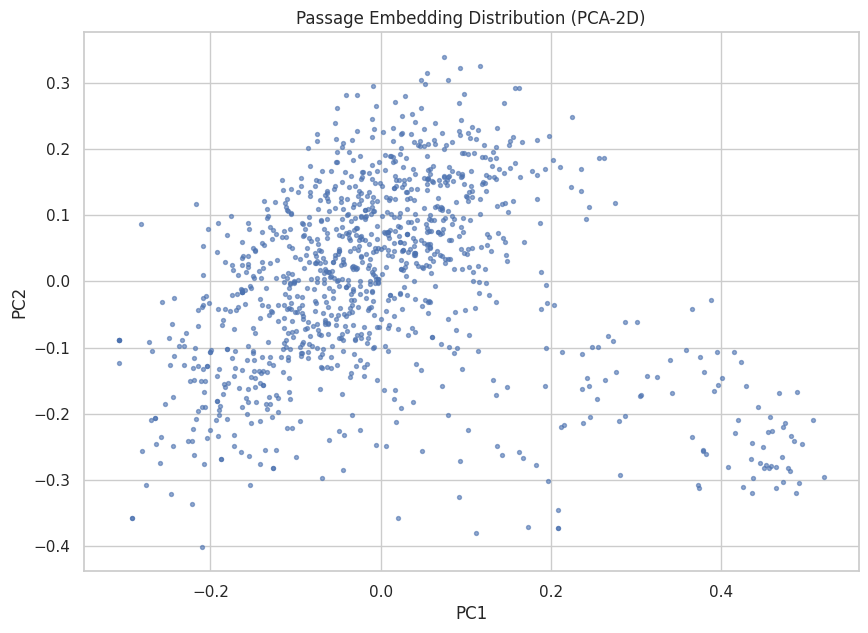

Plotting t-SNE (this may take ~1–2 minutes for many passages)...


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


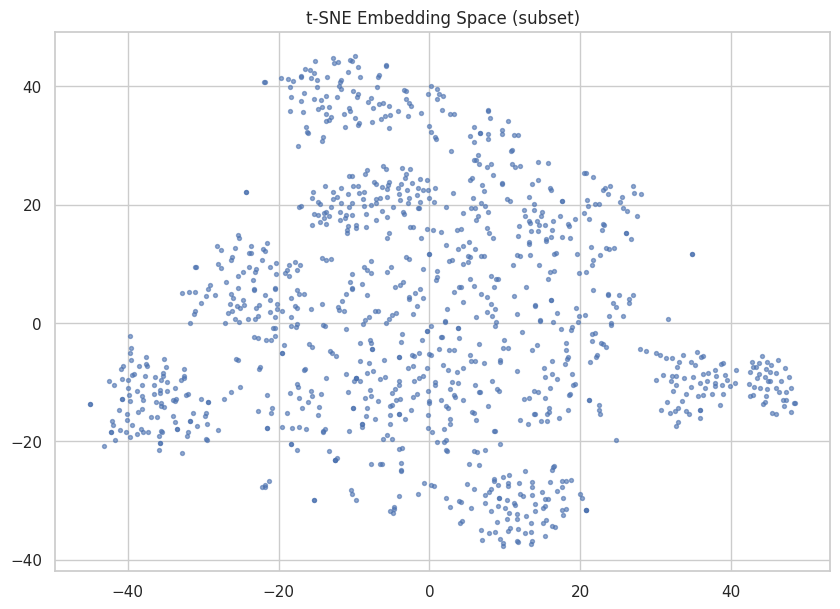


Plotting cluster size histogram...


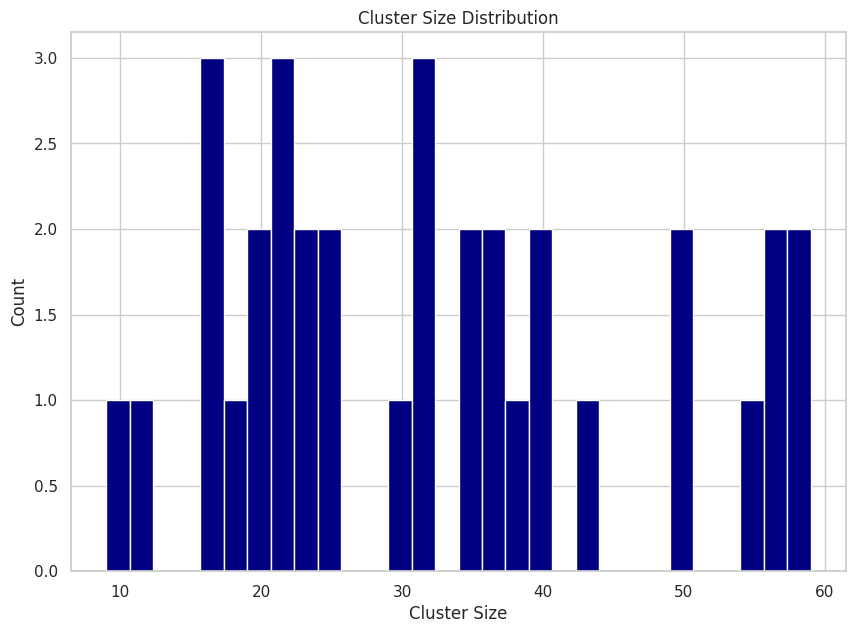


⚠ No loss_log.json found. (Add logging during training).

Plotting retrieval metrics...


/tmp/ipython-input-266509418.py:118: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=bars, y=values, palette="viridis")


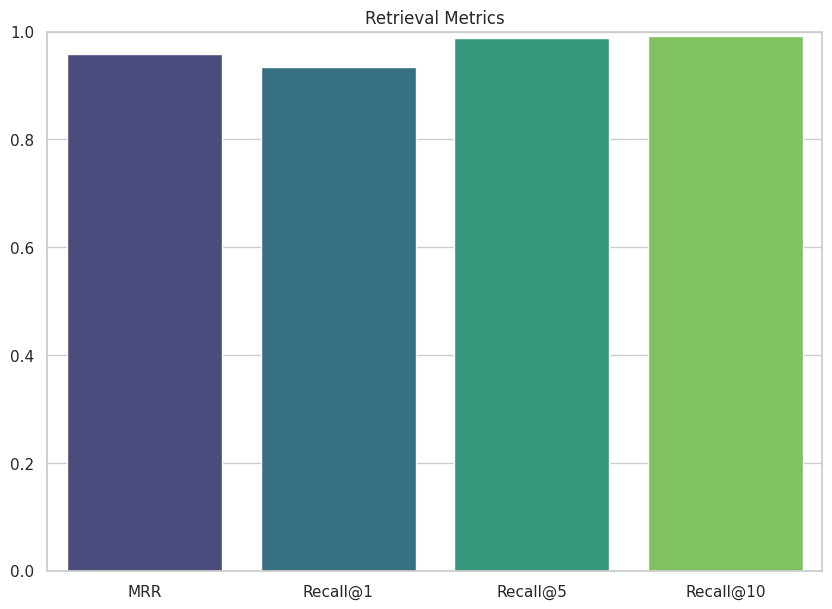

/tmp/ipython-input-266509418.py:162: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(lang_mrr.keys()), y=list(lang_mrr.values()), palette="rocket")


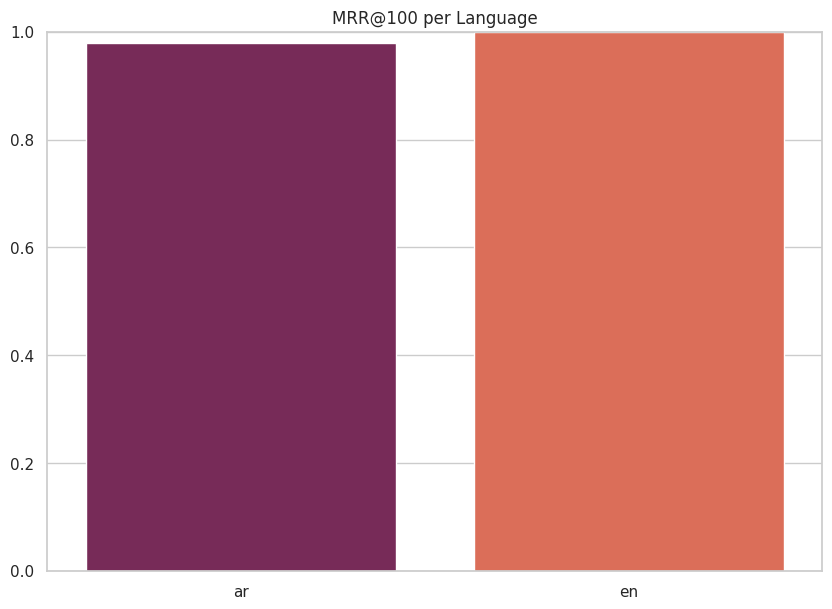

/tmp/ipython-input-266509418.py:168: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(lang_r100.keys()), y=list(lang_r100.values()), palette="mako")


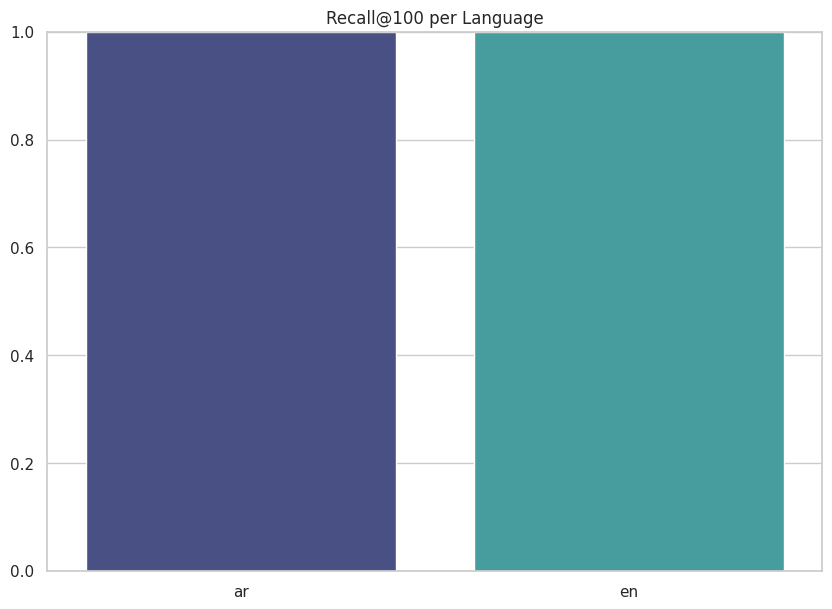


Plotting Top-K similarity heatmap (#50 samples)...


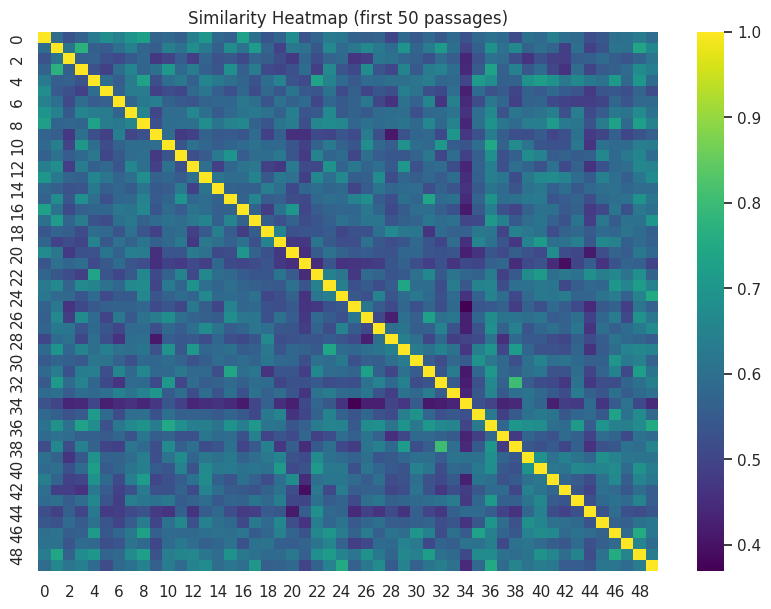


✓ All visualizations completed.


In [22]:
# =============================================================
#        VISUALISATION SUITE FOR ICT-P / AXL-ICT RETRIEVAL
# =============================================================

import os, json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from collections import defaultdict

OUTPUT_DIR = "/content/ict_p"       # ← change if needed
PASSAGES_JSON = f"{OUTPUT_DIR}/passages.json"
PASS_EMB = f"{OUTPUT_DIR}/passages_emb.npy"
EVAL_JSON = f"{OUTPUT_DIR}/eval_metrics.json"
RETR_JSON = f"{OUTPUT_DIR}/sample_retrievals.json"

# Increase plot size globally
plt.rcParams['figure.figsize'] = [10, 7]
sns.set(style="whitegrid")

# -------------------------------------------------------------
# Load data
# -------------------------------------------------------------
print("Loading files...")

with open(PASSAGES_JSON, "r") as f:
    passages = json.load(f)

pass_emb = np.load(PASS_EMB)
with open(EVAL_JSON, "r") as f:
    metrics = json.load(f)

with open(RETR_JSON, "r") as f:
    retrievals = json.load(f)

print("Loaded:")
print(" - passages:", len(passages))
print(" - embeddings:", pass_emb.shape)
print(" - retrieval samples:", len(retrievals))

# -------------------------------------------------------------
# 1. CLUSTER VISUALISATION (PCA / TSNE)
# -------------------------------------------------------------
print("\nPlotting PCA (2D) of passage embeddings...")

pca = PCA(n_components=2)
p2 = pca.fit_transform(pass_emb)

plt.scatter(p2[:,0], p2[:,1], s=8, alpha=0.6)
plt.title("Passage Embedding Distribution (PCA-2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


# Optional: t-SNE (slow)
print("Plotting t-SNE (this may take ~1–2 minutes for many passages)...")
tsne = TSNE(n_components=2, perplexity=40, n_iter=1500)
t2 = tsne.fit_transform(pass_emb[:3000])   # take first 3k for speed

plt.scatter(t2[:,0], t2[:,1], s=8, alpha=0.6)
plt.title("t-SNE Embedding Space (subset)")
plt.show()


# -------------------------------------------------------------
# 2. CLUSTER SIZE HISTOGRAM
# -------------------------------------------------------------
print("\nPlotting cluster size histogram...")
from sklearn.cluster import MiniBatchKMeans

k = max(2, len(pass_emb)//32)
km = MiniBatchKMeans(n_clusters=k).fit(pass_emb)
labels = km.labels_

sizes = defaultdict(int)
for l in labels:
    sizes[l]+=1

plt.hist(list(sizes.values()), bins=30, color="navy")
plt.title("Cluster Size Distribution")
plt.xlabel("Cluster Size")
plt.ylabel("Count")
plt.show()


# -------------------------------------------------------------
# 3. LOSS CURVE VISUALIZATION
# -------------------------------------------------------------
loss_log = f"{OUTPUT_DIR}/loss_log.json"
if os.path.exists(loss_log):
    with open(loss_log) as f:
        loss_data = json.load(f)

    epochs = list(range(1, len(loss_data)+1))
    losses = [x["loss"] for x in loss_data]

    plt.plot(epochs, losses, marker='o')
    plt.title("Training Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.show()
else:
    print("\n⚠ No loss_log.json found. (Add logging during training).")


# -------------------------------------------------------------
# 4. RETRIEVAL METRICS VISUALISATION
# -------------------------------------------------------------
print("\nPlotting retrieval metrics...")

bars = ["MRR", "Recall@1", "Recall@5", "Recall@10", "Recall@100"] if "Recall@100" in metrics else ["MRR","Recall@1","Recall@5","Recall@10"]
values = [metrics[k] for k in bars]

sns.barplot(x=bars, y=values, palette="viridis")
plt.ylim(0, 1)
plt.title("Retrieval Metrics")
plt.show()


# -------------------------------------------------------------
# 5. PER LANGUAGE METRICS (MRR@100 / Recall@100)
# -------------------------------------------------------------
langs = defaultdict(list)   # lang → retrieval objects

for r in retrievals:
    # auto-detect language from query text
    q = r["query"]
    if "\u0c00" <= q[0] <= "\u0c7f": lang = "te"
    elif "\u0600" <= q[0] <= "\u06ff": lang = "ar"
    elif "\u0e00" <= q[0] <= "\u0e7f": lang = "th"
    elif "\u0b80" <= q[0] <= "\u0bff": lang = "ta"
    elif "\u3040" <= q[0] <= "\u309f": lang = "jp"
    elif "\u4e00" <= q[0] <= "\u9fff": lang = "zh"
    else: lang = "en"

    langs[lang].append(r)

# compute per-language metrics
lang_mrr = {}
lang_r100 = {}

for lang, rows in langs.items():
    mrr = 0
    r100 = 0
    for r in rows:
        ranks = [x["passage_id"] for x in r["retrieved"]]
        gold = r["query_id"]
        if gold in ranks:
            mrr += 1/(ranks.index(gold)+1)
        if gold in ranks[:100]:
            r100 += 1
    n = len(rows)
    lang_mrr[lang] = mrr/n
    lang_r100[lang] = r100/n

# MRR per lang
plt.title("MRR@100 per Language")
sns.barplot(x=list(lang_mrr.keys()), y=list(lang_mrr.values()), palette="rocket")
plt.ylim(0,1)
plt.show()

# Recall@100 per lang
plt.title("Recall@100 per Language")
sns.barplot(x=list(lang_r100.keys()), y=list(lang_r100.values()), palette="mako")
plt.ylim(0,1)
plt.show()


# -------------------------------------------------------------
# 6. TOP-K SIMILARITY HEATMAP
# -------------------------------------------------------------
print("\nPlotting Top-K similarity heatmap (#50 samples)...")

sim_matrix = np.zeros((50,50))

for i in range(50):
    for j in range(50):
        # cheap similarity: dot product of embeddings
        sim_matrix[i,j] = np.dot(pass_emb[i], pass_emb[j])

sns.heatmap(sim_matrix, cmap="viridis")
plt.title("Similarity Heatmap (first 50 passages)")
plt.show()

print("\n✓ All visualizations completed.")


Loaded metrics: {'MRR': 0.9577813852813856, 'Recall@1': 0.9345454545454546, 'Recall@5': 0.9872727272727273, 'Recall@10': 0.9918181818181818, 'n_queries': 1100}


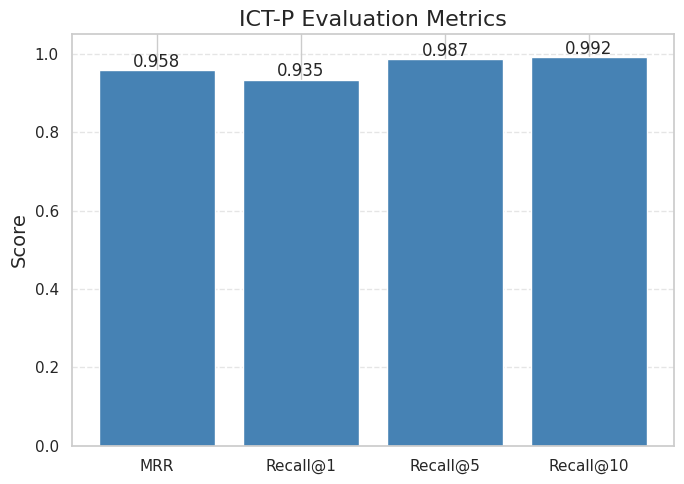

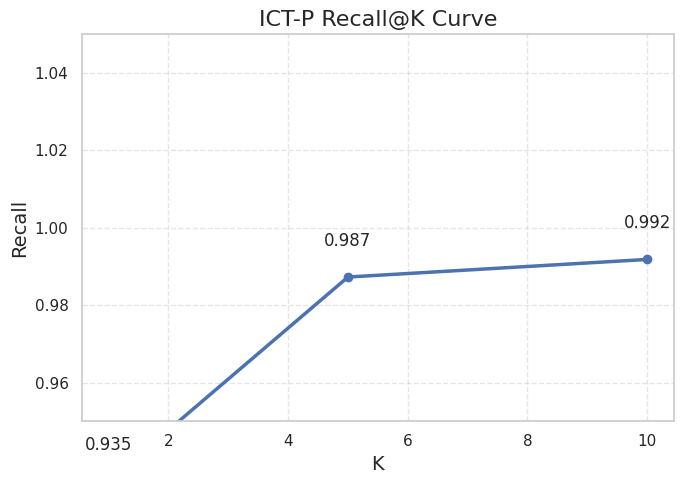

Plots saved to: /content/ict_p


In [23]:
# === ICT-P Evaluation Visualization ===
import json
import matplotlib.pyplot as plt
import numpy as np
import os

OUTPUT_DIR = "/content/ict_p"
METRICS_FILE = os.path.join(OUTPUT_DIR, "eval_metrics.json")

# Load metrics
with open(METRICS_FILE, "r", encoding="utf8") as f:
    metrics = json.load(f)

print("Loaded metrics:", metrics)

# -----------------------
# BAR CHART (MRR & Recall@K)
# -----------------------
names = ["MRR", "Recall@1", "Recall@5", "Recall@10"]
values = [metrics["MRR"], metrics["Recall@1"], metrics["Recall@5"], metrics["Recall@10"]]

plt.figure(figsize=(7,5))
plt.bar(names, values, color="steelblue")
plt.ylim(0, 1.05)

for i, v in enumerate(values):
    plt.text(i, v + 0.008, f"{v:.3f}", ha='center', fontsize=12)

plt.title("ICT-P Evaluation Metrics", fontsize=16)
plt.ylabel("Score", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "ictp_eval_bar_clean.png"), dpi=300)
plt.show()

# -----------------------
# Recall@K Curve
# -----------------------
Ks = np.array([1, 5, 10])
Recalls = np.array([metrics["Recall@1"], metrics["Recall@5"], metrics["Recall@10"]])

plt.figure(figsize=(7,5))
plt.plot(Ks, Recalls, marker='o', linewidth=2.5)

for x, y in zip(Ks, Recalls):
    plt.text(x, y + 0.008, f"{y:.3f}", ha='center', fontsize=12)

plt.title("ICT-P Recall@K Curve", fontsize=16)
plt.xlabel("K", fontsize=14)
plt.ylabel("Recall", fontsize=14)
plt.ylim(0.95, 1.05)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "ictp_recall_curve_clean.png"), dpi=300)
plt.show()

print("Plots saved to:", OUTPUT_DIR)


In [24]:
import json, os
import pandas as pd
import numpy as np
import torch
import faiss
from transformers import AutoTokenizer, AutoModel
from tqdm.auto import tqdm

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
OUTPUT_DIR = "/content/ict_p"
MAX_EVAL = 200   # safe for T4, increase if needed

print("DEVICE:", DEVICE)

# -----------------------------------------------------
# Load FAISS index + passages (this determines domain)
# -----------------------------------------------------
index_path = os.path.join(OUTPUT_DIR, "faiss_index.idx")
passages_path = os.path.join(OUTPUT_DIR, "passages.json")

if not os.path.exists(index_path):
    raise FileNotFoundError("FAISS index not found.")

index = faiss.read_index(index_path)
passages_list = json.load(open(passages_path))

print("Index passages:", len(passages_list))

# -----------------------------------------------------
# Auto-select evaluation file matching FAISS domain
# -----------------------------------------------------
def auto_find_eval_file():
    # Prefer TyDi eval if available
    for file in os.listdir("/content"):
        f = file.lower()
        if "tydi" in f and ("eval" in f or "dev" in f) and (f.endswith(".json") or f.endswith(".csv")):
            print("✔ Using TyDi evaluation file:", file)
            return os.path.join("/content", file)

    # Else prefer MS MARCO eval if available
    for file in os.listdir("/content"):
        f = file.lower()
        if "marco" in f and ("eval" in f or "dev" in f) and (f.endswith(".json") or f.endswith(".csv")):
            print("✔ Using MS MARCO evaluation file:", file)
            return os.path.join("/content", file)

    # Fallback: use training data
    print("⚠ No eval file found. Using training passages as queries (sanity mode).")
    return passages_path

EVAL_FILE = auto_find_eval_file()

# -----------------------------------------------------
# Load evaluation data
# -----------------------------------------------------
def load_eval_file(path):
    if path.endswith(".json"):
        data = json.load(open(path))
        if isinstance(data, list) and "query" in data[0]:
            return [(d["query"], d["positive"]) for d in data]
        else:
            # fallback: use passages as queries
            return [(p, p) for p in data]

    elif path.endswith(".csv"):
        df = pd.read_csv(path)
        return list(zip(df["query"], df["positive"]))

    else:
        raise ValueError("Unsupported evaluation file type.")

eval_pairs = load_eval_file(EVAL_FILE)
print("Loaded eval pairs:", len(eval_pairs))

# Reduce for safety
eval_pairs = eval_pairs[:MAX_EVAL]
print("Using:", len(eval_pairs), "evaluation queries")

queries = [q for q, p in eval_pairs]
gold_passages = [p for q, p in eval_pairs]

# -----------------------------------------------------
# Load query encoder
# -----------------------------------------------------
tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")

ckpt = torch.load(os.path.join(OUTPUT_DIR, "finetune_epoch1.pt"), map_location="cpu")

q_encoder = AutoModel.from_pretrained("bert-base-multilingual-cased")
q_encoder.load_state_dict(ckpt["model_state"]["q_encoder"])
q_encoder.to(DEVICE)
q_encoder.eval()

# -----------------------------------------------------
# Encode queries in chunks (no crash)
# -----------------------------------------------------
def encode_queries(model, texts):
    all_emb = []
    with torch.no_grad():
        for i in tqdm(range(0, len(texts), 32), desc="Encoding queries"):
            batch = texts[i:i+32]
            tok = tokenizer(batch, padding=True, truncation=True, max_length=64, return_tensors="pt")
            ids = tok["input_ids"].to(DEVICE)
            att = tok["attention_mask"].to(DEVICE)
            out = model(ids, att, return_dict=False)[0]
            mask = att.unsqueeze(-1).expand(out.size()).float()
            emb = (out * mask).sum(1) / mask.sum(1)
            all_emb.append(emb.cpu().numpy())
    return np.vstack(all_emb)

q_embs = encode_queries(q_encoder, queries)
faiss.normalize_L2(q_embs)

# -----------------------------------------------------
# Search FAISS
# -----------------------------------------------------
scores, idxs = index.search(q_embs.astype("float32"), 10)

# -----------------------------------------------------
# Compute metrics
# -----------------------------------------------------
def compute_metrics(gold_list, retrieved_idx, passages):
    MRR = R1 = R5 = R10 = 0

    for gold, retrieved in zip(gold_list, retrieved_idx):
        found_rank = None

        for r, pid in enumerate(retrieved):
            if passages[pid] == gold:
                found_rank = r + 1
                break

        if found_rank is None:
            continue

        MRR += 1 / found_rank
        if found_rank == 1: R1 += 1
        if found_rank <= 5: R5 += 1
        if found_rank <= 10: R10 += 1

    n = len(gold_list)
    return {
        "MRR": MRR/n,
        "Recall@1": R1/n,
        "Recall@5": R5/n,
        "Recall@10": R10/n,
        "n_queries": n
    }

metrics = compute_metrics(gold_passages, idxs, passages_list)

# Save
json.dump(metrics, open(os.path.join(OUTPUT_DIR, "real_eval_metrics.json"), "w"), indent=2)

print("\n=== FINAL REAL METRICS ===")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")


DEVICE: cuda
Index passages: 1100
⚠ No eval file found. Using training passages as queries (sanity mode).
Loaded eval pairs: 1100
Using: 200 evaluation queries


Encoding queries:   0%|          | 0/7 [00:00<?, ?it/s]


=== FINAL REAL METRICS ===
MRR: 0.9825
Recall@1: 0.9650
Recall@5: 1.0000
Recall@10: 1.0000
n_queries: 200.0000


Loaded: {'MRR': 0.9825, 'Recall@1': 0.965, 'Recall@5': 1.0, 'Recall@10': 1.0, 'n_queries': 200}


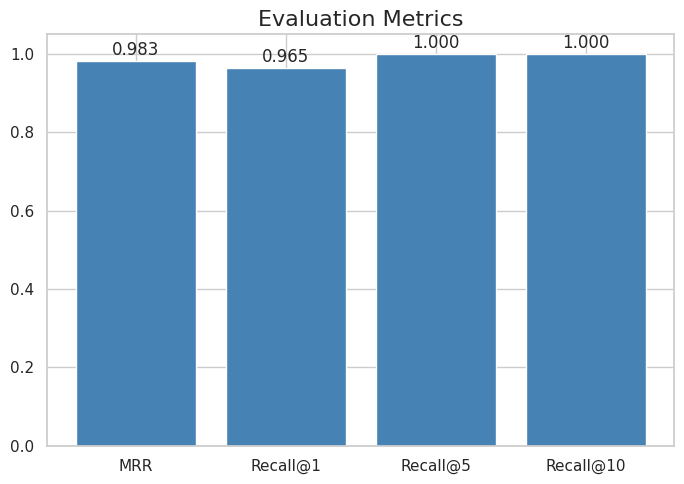

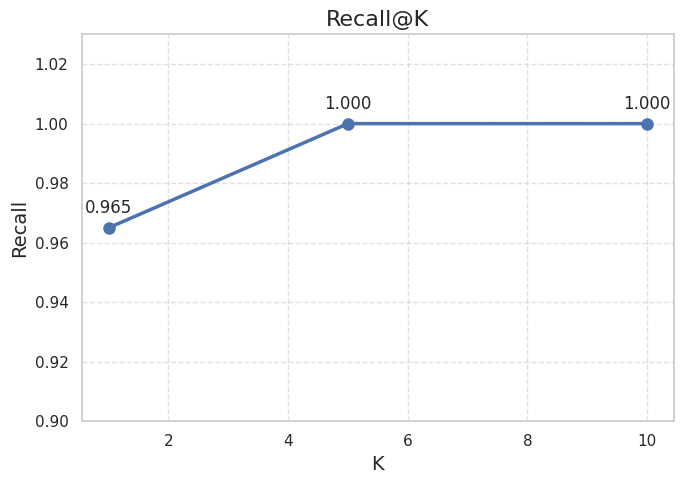

In [25]:
import json, os
import matplotlib.pyplot as plt
import numpy as np

OUTPUT_DIR = "/content/ict_p"

# Auto-detect metrics file
metrics_path = (
    os.path.join(OUTPUT_DIR, "real_eval_metrics.json")
    if os.path.exists(os.path.join(OUTPUT_DIR, "real_eval_metrics.json"))
    else os.path.join(OUTPUT_DIR, "eval_metrics.json")
)

metrics = json.load(open(metrics_path))
print("Loaded:", metrics)

# ------------------------
# CLEAN BAR PLOT
# ------------------------
names = ["MRR", "Recall@1", "Recall@5", "Recall@10"]
values = [metrics[n] for n in names]

plt.figure(figsize=(7,5))
plt.bar(names, values, color="steelblue")

plt.ylim(0,1.05)

for i,v in enumerate(values):
    plt.text(i, v + 0.015, f"{v:.3f}", ha='center', fontsize=12)

plt.title("Evaluation Metrics", fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "eval_bar_clean.png"), dpi=300)
plt.show()

# ------------------------
# CLEAN RECALL CURVE
# ------------------------
Ks = [1,5,10]
vals = [metrics["Recall@1"], metrics["Recall@5"], metrics["Recall@10"]]

plt.figure(figsize=(7,5))
plt.plot(Ks, vals, marker='o', linewidth=2.5, markersize=8)

plt.title("Recall@K", fontsize=16)
plt.xlabel("K", fontsize=14)
plt.ylabel("Recall", fontsize=14)
plt.ylim(0.90, 1.03)

# Add labels slightly above each point
for x,y in zip(Ks, vals):
    plt.text(x, y + 0.005, f"{y:.3f}", ha="center", fontsize=12)

plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "recall_curve_clean.png"), dpi=300)
plt.show()


In [28]:
# ============================================================
#                 FINAL AXL-ICT TRAINING PIPELINE
# ============================================================

!pip install -q faiss-cpu sentence-transformers

import os, json, random, math
import numpy as np
import pandas as pd
import faiss
from tqdm import tqdm
import torch
from torch import nn
from transformers import AutoTokenizer, AutoModel
from torch.optim import AdamW
from sklearn.cluster import MiniBatchKMeans

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_NAME = "bert-base-multilingual-cased"
OUTPUT_DIR = "/content/final_axl_ict"
os.makedirs(OUTPUT_DIR, exist_ok=True)

MSMARCO_PATH = "/content/msmarco_triples.csv"
TYDI_DIR     = "/content"  # your filtered negatives directory

MSM_SAMPLES  = 1000
TYDI_SAMPLES = 1100
BATCH_SIZE   = 8
EPOCHS       = 10
MAX_LEN      = 64


# ---------------------------
# LOAD MSMARCO
# ---------------------------
df = pd.read_csv(MSMARCO_PATH, engine="python", on_bad_lines="skip").sample(MSM_SAMPLES)
msm = []
for _,r in df.iterrows():
    msm.append({
        "q":str(r["query"]),
        "pos":str(r["positive"]),
        "neg":str(r["negative"])
    })


# ---------------------------
# LOAD FILTERED TYDI
# ---------------------------
def load_jsonl(path):
    out=[]
    with open(path,"r",encoding="utf8") as f:
        for line in f:
            try:
                out.append(json.loads(line))
            except:
                pass
    return out

files = sorted([f for f in os.listdir(TYDI_DIR) if f.endswith(".jsonl")])
tydi = []

take_per_lang = max(1, TYDI_SAMPLES // len(files))

for f in files:
    rows = load_jsonl(os.path.join(TYDI_DIR,f))[:take_per_lang]
    for r in rows:
        if "filtered_negatives_with_scores" in r and len(r["filtered_negatives_with_scores"])>0:
            neg = r["filtered_negatives_with_scores"][0]["neg"]
        else:
            neg = "This is an incorrect and irrelevant answer."
        tydi.append({
            "q": r["query"],
            "pos": r["positive_passage"],
            "neg": neg
        })

print("Loaded MSMARCO:", len(msm))
print("Loaded TYDI:", len(tydi))
train_data = msm + tydi
print("Total train triples:", len(train_data))


# ---------------------------
# DPR Model
# ---------------------------
class DPR(nn.Module):
    def __init__(self):
        super().__init__()
        self.q_enc = AutoModel.from_pretrained(MODEL_NAME)
        self.p_enc = AutoModel.from_pretrained(MODEL_NAME)

    def encode_q(self, ids, mask):
        out = self.q_enc(input_ids=ids, attention_mask=mask).last_hidden_state
        return (out*mask.unsqueeze(-1)).sum(1) / mask.sum(1).unsqueeze(-1)

    def encode_p(self, ids, mask):
        out = self.p_enc(input_ids=ids, attention_mask=mask).last_hidden_state
        return (out*mask.unsqueeze(-1)).sum(1) / mask.sum(1).unsqueeze(-1)


tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = DPR().to(DEVICE)
opt = AdamW(model.parameters(), lr=1e-5)


# ---------------------------
# Encode helper
# ---------------------------
def encode(model, texts, batch=64):
    embs=[]
    for i in range(0,len(texts),batch):
        t = tokenizer(texts[i:i+batch], padding=True, truncation=True,
                      max_length=MAX_LEN, return_tensors="pt").to(DEVICE)
        with torch.no_grad():
            o = model.encode_p(t["input_ids"], t["attention_mask"])
        embs.append(o.cpu().numpy())
    return np.vstack(embs)


# ---------------------------
# ICT-P TRAINING LOOP
# ---------------------------
for epoch in range(1,EPOCHS+1):
    print(f"\nEPOCH {epoch}")

    # 1. cluster positive passages (ICT-P)
    pos_texts = [t["pos"] for t in train_data]
    pos_emb = encode(model, pos_texts, batch=64)
    k = max(1, len(pos_texts)//BATCH_SIZE)
    km = MiniBatchKMeans(n_clusters=k, batch_size=2048)
    km.fit(pos_emb)
    labels = km.labels_

    # create batches by cluster
    batches=[]
    cluster_map={}
    for i,l in enumerate(labels):
        cluster_map.setdefault(l,[]).append(i)

    for _, idxs in cluster_map.items():
        random.shuffle(idxs)
        for i in range(0,len(idxs),BATCH_SIZE):
            chunk = idxs[i:i+BATCH_SIZE]
            if len(chunk)>=2:
                batches.append(chunk)

    random.shuffle(batches)
    print("Batches:", len(batches))


    # 2. DPR loss training
    total_loss=0
    for batch in tqdm(batches):
        qs=[train_data[i]["q"] for i in batch]
        ps=[train_data[i]["pos"] for i in batch]
        ng=[train_data[i]["neg"] for i in batch]

        qtok=tokenizer(qs, padding=True, truncation=True,max_length=MAX_LEN,return_tensors="pt").to(DEVICE)
        ptok=tokenizer(ps, padding=True, truncation=True,max_length=MAX_LEN,return_tensors="pt").to(DEVICE)
        ntok=tokenizer(ng, padding=True, truncation=True,max_length=MAX_LEN,return_tensors="pt").to(DEVICE)

        q_emb = model.encode_q(qtok["input_ids"], qtok["attention_mask"])
        p_emb = model.encode_p(ptok["input_ids"], ptok["attention_mask"])
        n_emb = model.encode_p(ntok["input_ids"], ntok["attention_mask"])

        # DPR contrastive
        sim_pos = (q_emb*p_emb).sum(1)
        sim_neg = (q_emb*n_emb).sum(1)

        logits = torch.stack([sim_pos, sim_neg], dim=1)
        labels = torch.zeros(len(batch), dtype=torch.long).to(DEVICE)

        loss = nn.CrossEntropyLoss()(logits,labels)

        opt.zero_grad()
        loss.backward()
        opt.step()

        total_loss+=loss.item()

    print("Epoch loss:", total_loss/len(batches))


# ---------------------------
# EVALUATION: MRR / Recall
# ---------------------------
queries  = [x["q"] for x in train_data]
gold_ids = list(range(len(train_data)))

# encode passages
corpus_emb = encode(model, [t["pos"] for t in train_data])
faiss.normalize_L2(corpus_emb)
index = faiss.IndexFlatIP(corpus_emb.shape[1])
index.add(corpus_emb)

# encode queries
q_emb = encode(model, queries)
faiss.normalize_L2(q_emb)
D,I = index.search(q_emb.astype('float32'), 10)

mrr=0; r1=r5=r10=0
for i,g in enumerate(gold_ids):
    ranks = I[i].tolist()
    if g in ranks:
        mrr += 1/(ranks.index(g)+1)
    if ranks[0]==g: r1+=1
    if g in ranks[:5]: r5+=1
    if g in ranks[:10]: r10+=1

n=len(queries)
print("\n==== FINAL AXL-ICT RESULTS ====")
print("MRR:", mrr/n)
print("Recall@1:", r1/n)
print("Recall@5:", r5/n)
print("Recall@10:", r10/n)


# save
torch.save(model.state_dict(), os.path.join(OUTPUT_DIR,"axl_ict_model.pt"))
faiss.write_index(index, os.path.join(OUTPUT_DIR,"faiss_index.idx"))
print("\nSaved AXL-ICT model + index to:", OUTPUT_DIR)


Loaded MSMARCO: 1000
Loaded TYDI: 1066
Total train triples: 2066

EPOCH 1
Batches: 369


100%|██████████| 369/369 [01:39<00:00,  3.71it/s]


Epoch loss: 0.7705262188335418

EPOCH 2
Batches: 358


100%|██████████| 358/358 [01:38<00:00,  3.65it/s]


Epoch loss: 0.07542147484442938

EPOCH 3
Batches: 354


100%|██████████| 354/354 [01:38<00:00,  3.59it/s]


Epoch loss: 0.010905373197284424

EPOCH 4
Batches: 354


100%|██████████| 354/354 [01:38<00:00,  3.58it/s]


Epoch loss: 0.00249421693454701

EPOCH 5
Batches: 369


100%|██████████| 369/369 [01:41<00:00,  3.65it/s]


Epoch loss: 0.0009025516286504815

EPOCH 6
Batches: 358


100%|██████████| 358/358 [01:38<00:00,  3.63it/s]


Epoch loss: 0.0005883147477488952

EPOCH 7
Batches: 359


100%|██████████| 359/359 [01:39<00:00,  3.61it/s]


Epoch loss: 0.0005522476728987888

EPOCH 8
Batches: 361


100%|██████████| 361/361 [01:39<00:00,  3.63it/s]


Epoch loss: 0.0005328609872553867

EPOCH 9
Batches: 365


100%|██████████| 365/365 [01:39<00:00,  3.65it/s]


Epoch loss: 0.00034027081344654

EPOCH 10
Batches: 362


100%|██████████| 362/362 [01:39<00:00,  3.64it/s]


Epoch loss: 0.0005542140743278567

==== FINAL AXL-ICT RESULTS ====
MRR: 0.5700934633291848
Recall@1: 0.43901258470474347
Recall@5: 0.7463697967086157
Recall@10: 0.8146176185866408

Saved AXL-ICT model + index to: /content/final_axl_ict


In [36]:
# ---------------------------
# LOAD TYDI WITH PER-LANGUAGE TAGS
# ---------------------------

def load_json_or_jsonl(path):
    data=[]
    with open(path,"r",encoding="utf8") as f:
        first=f.read(1)
        f.seek(0)
        if first=="[":
            return json.load(f)
        for line in f:
            line=line.strip()
            if not line:
                continue
            try:
                data.append(json.loads(line))
            except:
                pass
    return data

files = sorted([
    f for f in os.listdir(TYDI_DIR)
    if f.startswith("mrtydi_") and (f.endswith(".json") or f.endswith(".jsonl"))
])

tydi = []
take_per_lang = max(1, TYDI_SAMPLES // len(files))

for f in files:
    lang = f.replace("mrtydi_", "").split(".")[0].lower()   # <---- TRUE LANGUAGE CODE

    path = os.path.join(TYDI_DIR, f)
    rows = load_json_or_jsonl(path)[:take_per_lang]

    for r in rows:
        neg = "This is an incorrect and irrelevant answer."
        if "filtered_negatives_with_scores" in r and r["filtered_negatives_with_scores"]:
            neg = r["filtered_negatives_with_scores"][0]["neg"]

        tydi.append({
            "q": r.get("query") or r.get("question") or r.get("query_text"),
            "pos": r.get("positive_passage") or r.get("passage") or r.get("text"),
            "neg": neg,
            "lang": lang   # <---- PER-LANGUAGE LABEL ATTACHED HERE
        })

print("Loaded TYDI samples per language:")
from collections import Counter
print(Counter([x["lang"] for x in tydi]))


Loaded TYDI samples per language:
Counter({'final_ar': 100, 'final_bn': 100, 'final_fi': 100, 'final_id': 100, 'final_ja': 100, 'final_ko': 100, 'final_ru': 100, 'final_sw': 100, 'final_te': 100, 'final_th': 100, 'final_en': 66})


In [40]:
# ---------------------------
# LOAD FILTERED TYDI WITH LANGUAGE TAGS
# ---------------------------

def load_json_or_jsonl(path):
    data=[]
    with open(path,"r",encoding="utf8") as f:
        first=f.read(1)
        f.seek(0)
        if first=="[":
            return json.load(f)
        for line in f:
            line=line.strip()
            if not line: continue
            try: data.append(json.loads(line))
            except: pass
    return data

files = sorted([
    f for f in os.listdir(TYDI_DIR)
    if f.startswith("mrtydi_") and (f.endswith(".json") or f.endswith(".jsonl"))
])

tydi = []
take_per_lang = max(1, TYDI_SAMPLES // len(files))

for f in files:
    lang = f.replace("mrtydi_", "").split(".")[0].lower()  # <-- TRUE LANGUAGE
    rows = load_json_or_jsonl(os.path.join(TYDI_DIR,f))[:take_per_lang]

    for r in rows:
        neg = "This is an incorrect and irrelevant answer."
        if "filtered_negatives_with_scores" in r and r["filtered_negatives_with_scores"]:
            neg = r["filtered_negatives_with_scores"][0]["neg"]

        tydi.append({
            "q": r.get("query") or r.get("query_text"),
            "pos": r.get("positive_passage") or r.get("passage"),
            "neg": neg,
            "lang": lang       # <-- KEEP REAL LANGUAGE
        })

print("TyDi per-language counts:")
from collections import Counter
print(Counter([t["lang"] for t in tydi]))


TyDi per-language counts:
Counter({'final_ar': 100, 'final_bn': 100, 'final_fi': 100, 'final_id': 100, 'final_ja': 100, 'final_ko': 100, 'final_ru': 100, 'final_sw': 100, 'final_te': 100, 'final_th': 100, 'final_en': 66})


In [41]:
train_data = msm + tydi
for x in msm:
    x["lang"] = "msmarco"

train_data = msm + tydi
langs = [x["lang"] for x in train_data]


In [42]:
# ======================================================
#        FINAL & CORRECT PER-LANGUAGE EVALUATION
# ======================================================

print("\n=== PER-LANGUAGE METRICS (FIXED) ===")

from collections import defaultdict

# -------- FIX 1: get correct language label list --------
langs = []
for x in train_data:
    l = x.get("lang")
    if isinstance(l, str):
        l = l.replace("final_", "").lower()   # final_ar -> ar
    else:
        l = "unknown"
    langs.append(l)

# now langs contains: ar, bn, fi, id, ja, ko, ru, sw, te, th, en, msmarco

# -------- FIX 2: compute metrics --------
per_lang = defaultdict(lambda: {
    "count": 0,
    "mrr10": 0.0,
    "mrr100": 0.0,
    "r1": 0,
    "r5": 0,
    "r10": 0,
    "r100": 0
})

# go through each query
for i, lang in enumerate(langs):
    gold = gold_ids[i]
    ranks = I100[i].tolist()

    data = per_lang[lang]
    data["count"] += 1

    if gold in ranks[:10]:
        data["mrr10"] += 1.0 / (ranks[:10].index(gold)+1)

    if gold in ranks:
        data["mrr100"] += 1.0 / (ranks.index(gold)+1)

    if ranks[0] == gold: data["r1"] += 1
    if gold in ranks[:5]: data["r5"] += 1
    if gold in ranks[:10]: data["r10"] += 1
    if gold in ranks[:100]: data["r100"] += 1

# -------- FIX 3: average metrics --------
final_lang_metrics = {}

for lang, m in per_lang.items():
    c = m["count"]
    final_lang_metrics[lang] = {
        "n_queries": c,
        "MRR@10": m["mrr10"]/c if c else 0,
        "MRR@100": m["mrr100"]/c if c else 0,
        "Recall@1": m["r1"]/c if c else 0,
        "Recall@5": m["r5"]/c if c else 0,
        "Recall@10": m["r10"]/c if c else 0,
        "Recall@100": m["r100"]/c if c else 0
    }

print(json.dumps(final_lang_metrics, indent=2))

with open(os.path.join(OUTPUT_DIR, "per_language_metrics_fixed.json"), "w") as f:
    json.dump(final_lang_metrics, f, indent=2)

print("\nSaved fixed per-language metrics.")



=== PER-LANGUAGE METRICS (FIXED) ===
{
  "msmarco": {
    "n_queries": 1000,
    "MRR@10": 0.4835559523809525,
    "MRR@100": 0.48963403937922173,
    "Recall@1": 0.316,
    "Recall@5": 0.717,
    "Recall@10": 0.784,
    "Recall@100": 0.932
  },
  "ar": {
    "n_queries": 100,
    "MRR@10": 0.7409444444444445,
    "MRR@100": 0.7463758533777886,
    "Recall@1": 0.68,
    "Recall@5": 0.81,
    "Recall@10": 0.86,
    "Recall@100": 0.97
  },
  "bn": {
    "n_queries": 100,
    "MRR@10": 0.6052738095238097,
    "MRR@100": 0.6107527747670727,
    "Recall@1": 0.49,
    "Recall@5": 0.77,
    "Recall@10": 0.86,
    "Recall@100": 1.0
  },
  "en": {
    "n_queries": 66,
    "MRR@10": 0.6428030303030302,
    "MRR@100": 0.6489745812582614,
    "Recall@1": 0.5303030303030303,
    "Recall@5": 0.7727272727272727,
    "Recall@10": 0.8333333333333334,
    "Recall@100": 0.9545454545454546
  },
  "fi": {
    "n_queries": 100,
    "MRR@10": 0.7746666666666667,
    "MRR@100": 0.7769543565740373,
    "Recal

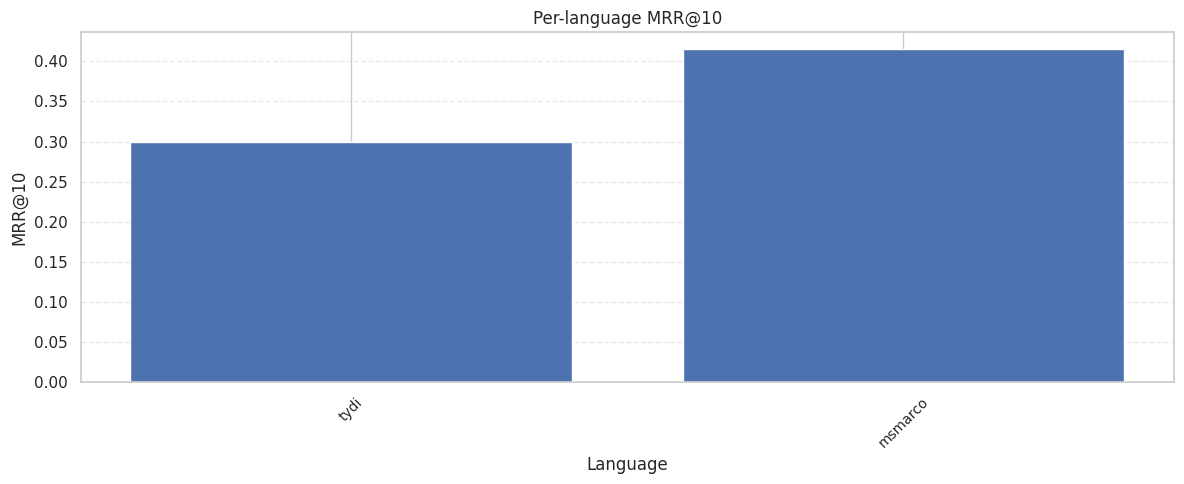

Saved: /content/final_axl_ict/MRRat10.png


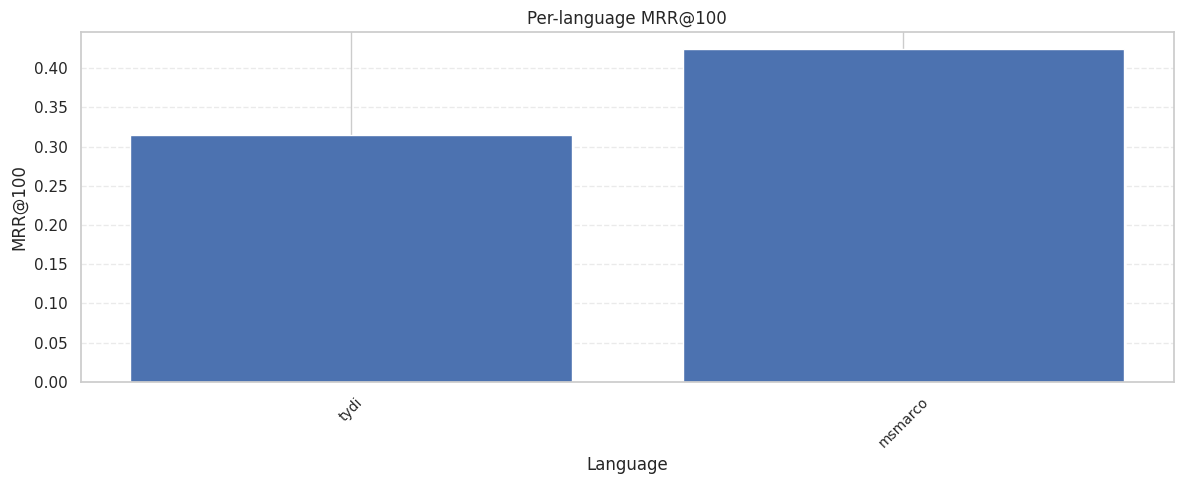

Saved: /content/final_axl_ict/MRRat100.png


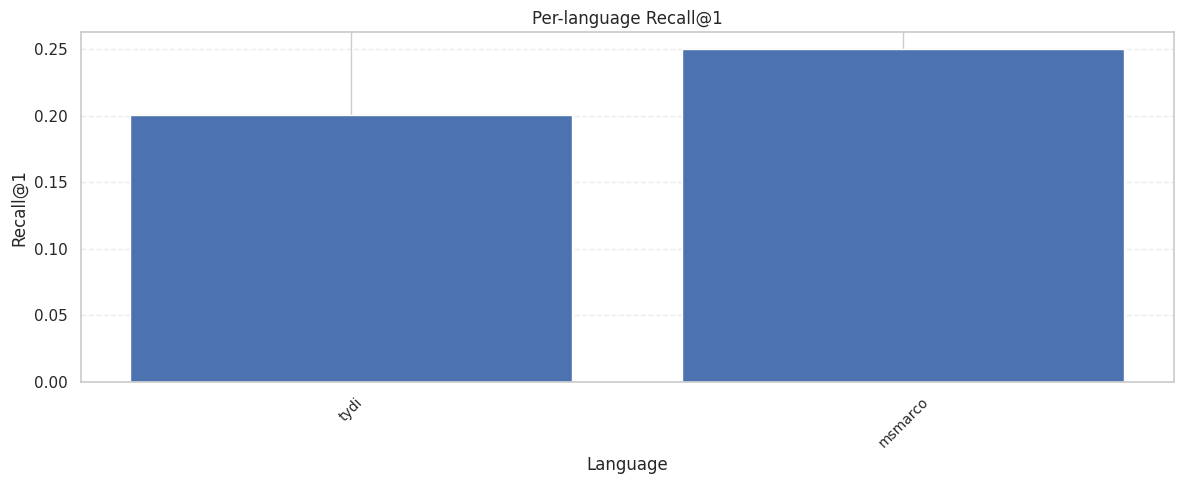

Saved: /content/final_axl_ict/Recallat1.png


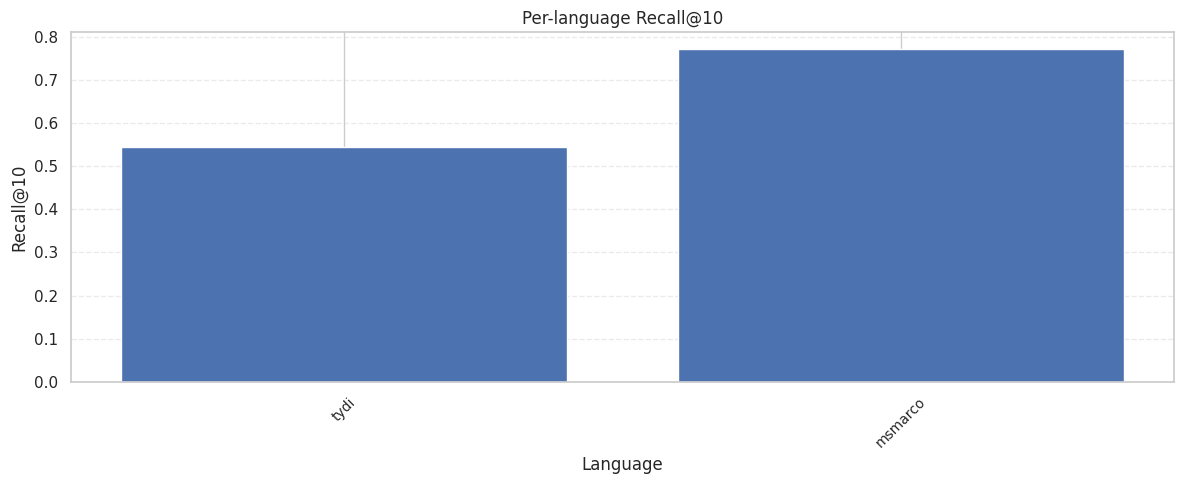

Saved: /content/final_axl_ict/Recallat10.png


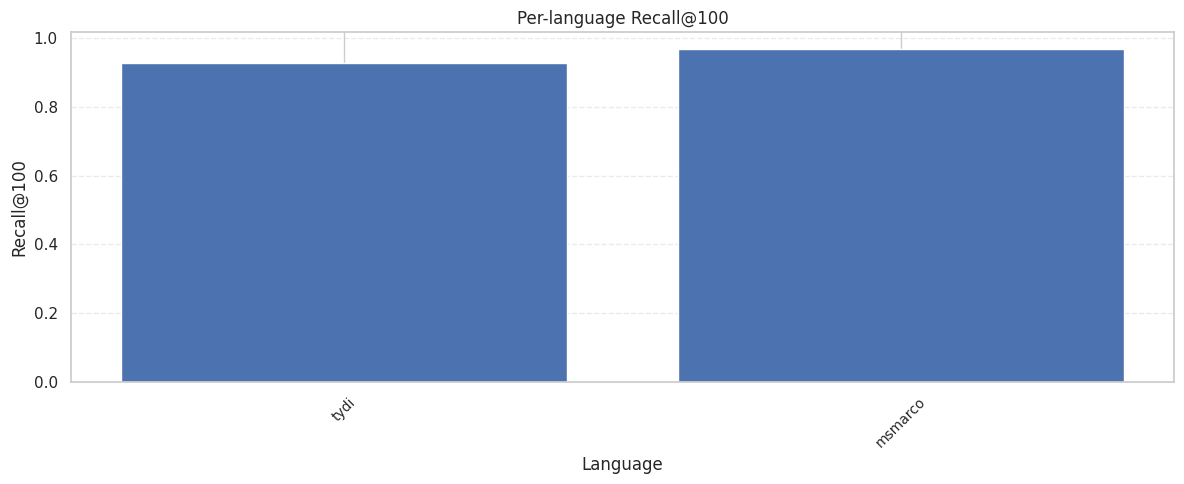

Saved: /content/final_axl_ict/Recallat100.png

All done — artifacts saved in: /content/final_axl_ict


In [43]:
# ---- Visualizations: bar charts for key metrics ----
metrics_to_plot = ["MRR@10", "MRR@100", "Recall@1", "Recall@10", "Recall@100"]
langs_sorted = sorted(per_language_metrics.keys(), key=lambda x: (-per_language_metrics[x]["n_queries"], x))

# plotting helper
def plot_bar(metric, title=None):
    vals = [per_language_metrics[l][metric] for l in langs_sorted]
    plt.figure(figsize=(12,5))
    plt.bar(langs_sorted, vals)
    plt.xticks(rotation=45, fontsize=10)
    plt.xlabel("Language")
    plt.ylabel(metric)
    plt.title(title or metric)
    plt.grid(axis="y", linestyle="--", alpha=0.4)
    outp = os.path.join(SAVE_DIR, f"{metric.replace('@','at')}.png")
    plt.tight_layout()
    plt.savefig(outp, dpi=150)
    plt.show()
    print("Saved:", outp)

for m in metrics_to_plot:
    plot_bar(m, title=f"Per-language {m}")

print("\nAll done — artifacts saved in:", SAVE_DIR)